In [2]:
import pandas as pd

In [3]:
train_path = './train.json'
data = pd.read_json(train_path)

pd.set_option("max_colwidth", 200)

data.head()

,id,cuisine,ingredients
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes, garlic, pepper, purple onion, seasoning, garbanzo beans, feta cheese crumbles]"
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, ground black pepper, thyme, eggs, green tomatoes, yellow corn meal, milk, vegetable oil]"
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, green chilies, grilled chicken breasts, garlic powder, yellow onion, soy sauce, butter, chicken livers]"
3,22213,indian,"[water, vegetable oil, wheat, salt]"
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pepper, onions, garlic paste, milk, butter, salt, lemon juice, water, chili powder, passata, oil, ground cumin, boneless chicken skinless thigh, garam m..."


In [4]:
data = data.drop(columns=['id'])

In [5]:
#from sklearn.model_selection import train_test_split

X = data['ingredients']
y = data['cuisine']

from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.20, random_state=42)

train_index, test_index = list(sss.split(X, y))[0]

## Naivni prediktor koji samo predvida talijansku kuhinju

In [6]:
from sklearn.base import BaseEstimator, ClassifierMixin

class BaselineClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y):
        pass
    
    def predict(self, X):
        return ["italian"] * X.shape[0]
    
    def score(self, X, y):
        return sum(self.predict(X) == y) / X.shape[0]

In [7]:
baseline = BaselineClassifier()

print(baseline.score(X[train_index], y[train_index]))
print(baseline.score(X[test_index], y[test_index]))

0.19705207580376505
0.19710873664362036


## Izgradnja matrice u kojem redak predstavlja recept, a stupci sastojak. Ako je na (i, j) mjestu u matrici 1 to znaci da je j-ti sastojak zastupljen u i-tom receptu

In [97]:
%%time

from collections import Counter

from unidecode import unidecode
from nltk.stem import WordNetLemmatizer
import nltk

def lemmantize(set_of_ing):
    lemmatizer = WordNetLemmatizer()
    # unidecode(word).lower() smanjio sa 3341 na 2912
    return set([lemmatizer.lemmatize(unidecode(word).lower()) 
                for word_list in [nltk.word_tokenize(ing) for ing in set_of_ing] 
                for word in word_list])


ingredients_counter = Counter(ingredient for ingredients_list in X.apply(set).apply(lemmantize)
                              for ingredient in ingredients_list)

print("Broj jedinstvenih sastojaka", len(ingredients_counter))

    
ingredientToInd = dict([(y, x) for x, y in enumerate(ingredients_counter)])
indToIngredient = dict([(x, y) for x, y in enumerate(ingredients_counter)])

Broj jedinstvenih sastojaka 2912
CPU times: user 27.9 s, sys: 39.6 ms, total: 28 s
Wall time: 28 s


In [98]:
from collections import Counter

from scipy.sparse import lil_matrix

# trebat ce matrica len(train) x broj_jedinstvenih_sastojaka -> 39774 x 3341 = 267042636 ~ 2 * 10^8
def create_cnt_matrix(ingredients_data):
    processed_data = ingredients_data.apply(set).apply(lemmantize)
    
    cnt_matrix = lil_matrix((len(ingredients_data), len(ingredients_counter)), dtype=bool, copy=False)

    for i, row in enumerate(processed_data):
        for ingredient in row:
            if ingredient in ingredientToInd:
                cnt_matrix[i, ingredientToInd[ingredient]] = 1
            
    return cnt_matrix

In [99]:
%%time

cnt_matrix = create_cnt_matrix(X)

CPU times: user 37 s, sys: 23.6 ms, total: 37.1 s
Wall time: 37.1 s


# Bag of words(lemmantize)

### Random forrest

In [62]:
%%time

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {'max_depth': [None],
              'min_samples_split': [2, 5],
              'n_estimators': [100, 200, 500],
             'max_features': [2, 5, 10, 20, 50]} 

grid_random_forest = GridSearchCV(RandomForestClassifier(), param_grid, refit = True, verbose = 3, n_jobs=4, 
                                  scoring='accuracy', return_train_score=True, cv = [(train_index, test_index)])

grid_random_forest.fit(cnt_matrix, y)

pd.DataFrame(grid_random_forest.cv_results_)[
    ['param_max_depth', 'param_n_estimators', 'param_max_features', 'param_min_samples_split',
     'split0_test_score', 'split0_train_score', 'rank_test_score']].sort_values(['rank_test_score'])

Fitting 1 folds for each of 30 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
/home/ltomic/anaconda3/envs/vjezbe/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed: 23.1min finished


CPU times: user 1min 59s, sys: 704 ms, total: 2min
Wall time: 25min 3s


,param_max_depth,param_n_estimators,param_max_features,split0_test_score,split0_train_score,rank_test_score
25,None,200,50,0.761911,0.999749,1
26,None,500,50,0.760528,0.999749,2
20,None,500,20,0.760277,0.999749,3
14,None,500,10,0.759522,0.999749,4
2,None,500,2,0.758265,0.999749,5
29,None,500,50,0.756757,0.988843,6
8,None,500,5,0.756128,0.999749,7
24,None,100,50,0.755877,0.999749,8
7,None,200,5,0.755374,0.999749,9
19,None,200,20,0.754117,0.999749,10


### Linear SVM

In [100]:
%%time

from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV

param_grid = {'C': [0.001, 0.1, 1, 10, 50, 100, 500, 1000, 5000],  
              'penalty': ['l1','l2'],
             'loss': ['hinge','squared hinge'],
             'class_weight': [None, 'balanced']} 

grid_linear_svm = GridSearchCV(LinearSVC(), param_grid, refit = True, verbose = 3, n_jobs=-2, scoring='accuracy',
                       return_train_score=True, cv = [(train_index, test_index)])

grid_linear_svm.fit(cnt_matrix, y)

pd.DataFrame(grid_linear_svm.cv_results_)[
    ['param_C', 'param_loss', 'param_penalty', 'split0_test_score', 
     'split0_train_score', 'rank_test_score']].sort_values(['rank_test_score'])

Fitting 1 folds for each of 72 candidates, totalling 72 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  18 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-2)]: Done  72 out of  72 | elapsed:  2.7min finished


CPU times: user 4.84 s, sys: 204 ms, total: 5.04 s
Wall time: 2min 42s


/home/ltomic/anaconda3/envs/vjezbe/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


,param_C,param_loss,param_penalty,split0_test_score,split0_train_score,rank_test_score
9,0.1,hinge,l2,0.771716,0.825356,1
17,1,hinge,l2,0.769579,0.865583,2
25,10,hinge,l2,0.759899,0.881392,3
13,0.1,hinge,l2,0.754243,0.816808,4
21,1,hinge,l2,0.753488,0.854929,5
...,...,...,...,...,...,...
70,5000,squared hinge,l1,NaN,NaN,68
36,50,hinge,l1,NaN,NaN,69
38,50,squared hinge,l1,NaN,NaN,70
20,1,hinge,l1,NaN,NaN,71


### SVM

In [77]:
%%time

from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier

svm = SVC(C=1, kernel='linear', degree=3,
          gamma=1, coef0=1, shrinking=True, 
          probability=False, tol=0.001, cache_size=1000,
          class_weight='balanced', verbose=True, max_iter=500,
          decision_function_shape='ovr', random_state=42)

model = OneVsRestClassifier(svm, n_jobs=4)
model.fit(cnt_matrix[train_index], y[train_index])

CPU times: user 37.4 s, sys: 112 ms, total: 37.5 s
Wall time: 1min 7s


OneVsRestClassifier(estimator=SVC(C=1, cache_size=1000, class_weight='balanced',
                                  coef0=1, gamma=1, kernel='linear',
                                  max_iter=500, random_state=42, verbose=True),
                    n_jobs=4)

In [78]:
%%time
print("train score: ", model.score(cnt_matrix[train_index], y[train_index]))
print("test score: ", model.score(cnt_matrix[test_index], y[test_index]))

train score:  0.4536597630346648
test score:  0.43896920175989945
CPU times: user 2min 52s, sys: 192 ms, total: 2min 52s
Wall time: 2min 52s


### gaussian naive bayes

In [91]:
%%time

from sklearn.naive_bayes import GaussianNB

gaussian_nb = GaussianNB()

gaussian_nb.fit(cnt_matrix[train_index].toarray(), y[train_index])

CPU times: user 2.03 s, sys: 396 ms, total: 2.43 s
Wall time: 2.43 s


GaussianNB()

In [92]:
%%time

print("train score: ", gaussian_nb.score(cnt_matrix[train_index].toarray(), y[train_index]))
print("test score: ", gaussian_nb.score(cnt_matrix[test_index].toarray(), y[test_index]))

train score:  0.3044407429523241
test score:  0.231803896920176
CPU times: user 10.4 s, sys: 4.48 s, total: 14.8 s
Wall time: 14.8 s


### multinomial naive bayes

In [93]:
%%time
from sklearn.naive_bayes import MultinomialNB

param_grid = {'alpha': [i * 0.01 for i in range(101)],
              'fit_prior': [False, True]
             } 

grid_multinomialNB = GridSearchCV(MultinomialNB(), param_grid, refit = True, verbose = 3, 
                                   n_jobs=-2, scoring='accuracy', cv = [(train_index, test_index)],
                                   return_train_score=True)

grid_multinomialNB.fit(cnt_matrix, y) 

pd.DataFrame(grid_multinomialNB.cv_results_)[
    ['param_alpha', 'param_fit_prior', 
     'split0_test_score', 'split0_train_score', 'rank_test_score']].sort_values(['rank_test_score'])

Fitting 1 folds for each of 202 candidates, totalling 202 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  18 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-2)]: Done 114 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-2)]: Done 202 out of 202 | elapsed:   23.1s finished


CPU times: user 6.02 s, sys: 255 ms, total: 6.28 s
Wall time: 23.6 s


,param_alpha,param_fit_prior,split0_test_score,split0_train_score,rank_test_score
135,0.67,True,0.731113,0.754769,1
133,0.66,True,0.730987,0.754738,2
131,0.65,True,0.730861,0.755021,3
157,0.78,True,0.730861,0.753575,3
145,0.72,True,0.730735,0.754361,5
...,...,...,...,...,...
2,0.01,False,0.693400,0.741538,198
14,0.07,False,0.693275,0.736572,199
18,0.09,False,0.692898,0.735567,200
16,0.08,False,0.692520,0.736164,201


### ComplementNB

In [97]:
%%time
from sklearn.naive_bayes import ComplementNB

param_grid = {'alpha': [i * 0.01 for i in range(101)],
              'norm': [False, True]
             } 

grid_complementNB = GridSearchCV(ComplementNB(), param_grid, refit = True, verbose = 3, 
                                   n_jobs=-2, scoring='accuracy', cv = [(train_index, test_index)],
                                   return_train_score=True)

grid_complementNB.fit(cnt_matrix, y) 

pd.DataFrame(grid_complementNB.cv_results_)[
    ['param_alpha', 'param_norm', 
     'split0_test_score', 'split0_train_score', 'rank_test_score']].sort_values(['rank_test_score'])

Fitting 1 folds for each of 202 candidates, totalling 202 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  18 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-2)]: Done 114 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-2)]: Done 202 out of 202 | elapsed:   22.7s finished


CPU times: user 5.91 s, sys: 795 ms, total: 6.71 s
Wall time: 23.2 s


,param_alpha,param_norm,split0_test_score,split0_train_score,rank_test_score
27,0.13,True,0.695915,0.718722,1
29,0.14,True,0.695663,0.719224,2
23,0.11,True,0.695663,0.719193,2
45,0.22,True,0.695537,0.716270,4
21,0.1,True,0.695537,0.719601,4
...,...,...,...,...,...
197,0.98,True,0.681835,0.699362,198
199,0.99,True,0.681835,0.699268,198
201,1.0,True,0.681332,0.699142,200
3,0.01,True,0.674041,0.698136,201


### BernoulliNB

In [99]:
from sklearn.naive_bayes import BernoulliNB

param_grid = {'alpha': [i * 0.01 for i in range(101)],
              'fit_prior': [False, True]
             } 

grid_bernoulliNB = GridSearchCV(BernoulliNB(), param_grid, refit = True, verbose = 3, 
                                   n_jobs=-2, scoring='accuracy', cv = [(train_index, test_index)],
                                   return_train_score=True)
grid_bernoulliNB.fit(cnt_matrix, y) 

pd.DataFrame(grid_bernoulliNB.cv_results_)[
    ['param_alpha', 'param_fit_prior', 
     'split0_test_score', 'split0_train_score', 'rank_test_score']].sort_values(['rank_test_score'])

Fitting 1 folds for each of 202 candidates, totalling 202 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  18 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-2)]: Done 114 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-2)]: Done 202 out of 202 | elapsed:   23.8s finished


,param_alpha,param_fit_prior,split0_test_score,split0_train_score,rank_test_score
127,0.63,True,0.720427,0.740721,1
101,0.5,True,0.720427,0.742764,1
129,0.64,True,0.720427,0.740532,1
111,0.55,True,0.720302,0.741947,4
113,0.56,True,0.720302,0.741727,4
...,...,...,...,...,...
8,0.04,False,0.679950,0.719539,197
10,0.05,False,0.679573,0.718596,199
4,0.02,False,0.679195,0.721644,200
6,0.03,False,0.679070,0.720481,201


### GradientBoostingClassifier

In [104]:
%%time

from sklearn.ensemble import GradientBoostingClassifier

param_grid = {'n_estimators': [i*20 for i in range(1, 5)],
              'learning_rate': [0.1, 0.25, 0.5, 1],
              'max_depth': [1, 2, 5]
             } 

grid_grad_boost = GridSearchCV(GradientBoostingClassifier(), param_grid, refit = True, verbose = 3, 
                                   n_jobs=6, scoring='accuracy', cv = [(train_index, test_index)],
                                   return_train_score=True)
grid_grad_boost.fit(cnt_matrix, y) 

pd.DataFrame(grid_grad_boost.cv_results_)[
    ['param_n_estimators', 'param_learning_rate', 'param_max_depth',
     'split0_test_score', 'split0_train_score', 'rank_test_score']].sort_values(['rank_test_score'])

Fitting 1 folds for each of 48 candidates, totalling 48 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 tasks      | elapsed: 17.7min
[Parallel(n_jobs=6)]: Done  48 out of  48 | elapsed: 32.7min finished


CPU times: user 2min 40s, sys: 488 ms, total: 2min 40s
Wall time: 35min 21s


,param_n_estimators,param_learning_rate,param_max_depth,split0_test_score,split0_train_score,rank_test_score
11,80,0.1,5,0.757134,0.885069,1
23,80,0.25,5,0.748209,0.939124,2
10,60,0.1,5,0.745066,0.865866,3
22,60,0.25,5,0.742426,0.924039,4
19,80,0.25,2,0.739158,0.798139,5
9,40,0.1,5,0.738529,0.834627,6
21,40,0.25,5,0.738278,0.897985,7
18,60,0.25,2,0.732747,0.783368,8
33,40,0.5,5,0.727593,0.840661,9
20,20,0.25,5,0.722313,0.842893,10


### HistGradientBoosting

In [31]:
%%time

from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {'learning_rate': [0.1, 0.2],
              'max_depth': [2]}

grid_hist_grad_boost = GridSearchCV(HistGradientBoostingClassifier(), param_grid, refit = True, verbose = 3, 
                                   n_jobs=1, scoring='accuracy', cv = [(train_index, test_index)],
                                   return_train_score=True)
grid_hist_grad_boost.fit(cnt_matrix.toarray(), y)

pd.DataFrame(grid_hist_grad_boost.cv_results_)[
    ['param_learning_rate', 'param_max_depth',
     'split0_test_score', 'split0_train_score', 'rank_test_score']].sort_values(['rank_test_score'])

Fitting 1 folds for each of 2 candidates, totalling 2 fits
[CV] learning_rate=0.1, max_depth=4 ..................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


KeyboardInterrupt: 

### Linear SVM confusion matrix

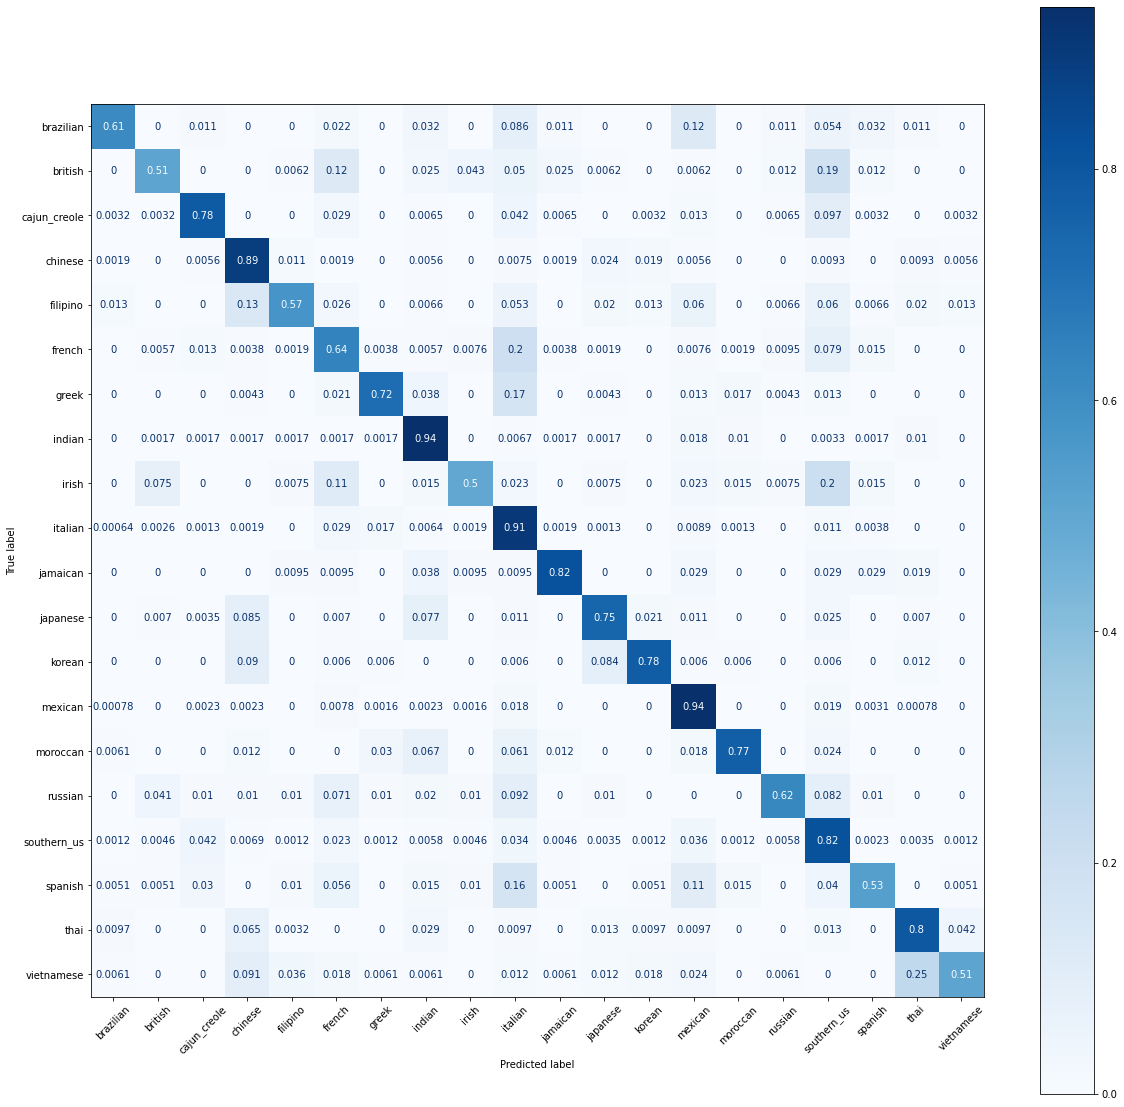

In [31]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

y_predicted = grid_linear_svm.predict(cnt_matrix[test_index])

fig, ax = plt.subplots(figsize=(20, 20))
disp = plot_confusion_matrix(grid_linear_svm, cnt_matrix[test_index], y[test_index], ax=ax,
                             cmap=plt.cm.Blues, normalize='true', xticks_rotation=45)

idemo ispisati najznacajnijih 20 sastojaka za svaku kuhinju

In [175]:
def plot_coefficients(classifier, cuisine_index, top_features=20):
    coef = classifier.coef_[cuisine_index]
    
    top_positive_coef = np.argsort(coef)[-top_features:]
    top_negative_coef = np.argsort(coef)[:top_features]
    
    top_coef = np.hstack([top_negative_coef, top_positive_coef])
    
    plt.figure(figsize=(15, 10))
    
    colors = ['red' if c < 0 else 'blue' for c in coef[top_coef]]
    
    plt.barh(np.arange(2 * top_features), coef[top_coef], color=colors)
    labels = [indToIngredient[coef_ind] for coef_ind in top_coef]
    plt.yticks(np.arange(0, 2 * top_features), labels, rotation=0, ha='right')
    plt.title(classifier.classes_[cuisine_index])
    plt.show()

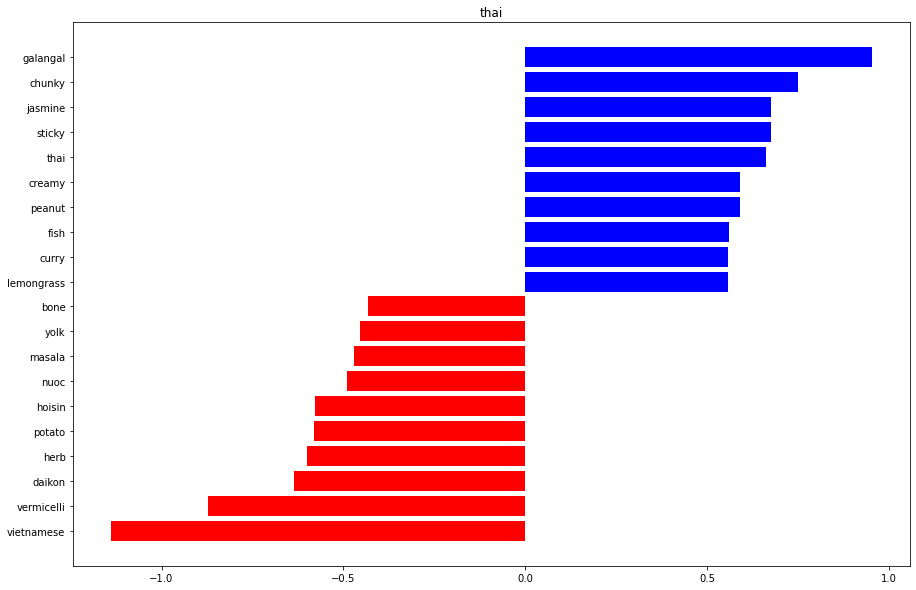

In [177]:
plot_coefficients(best_estimator, 18, 10)

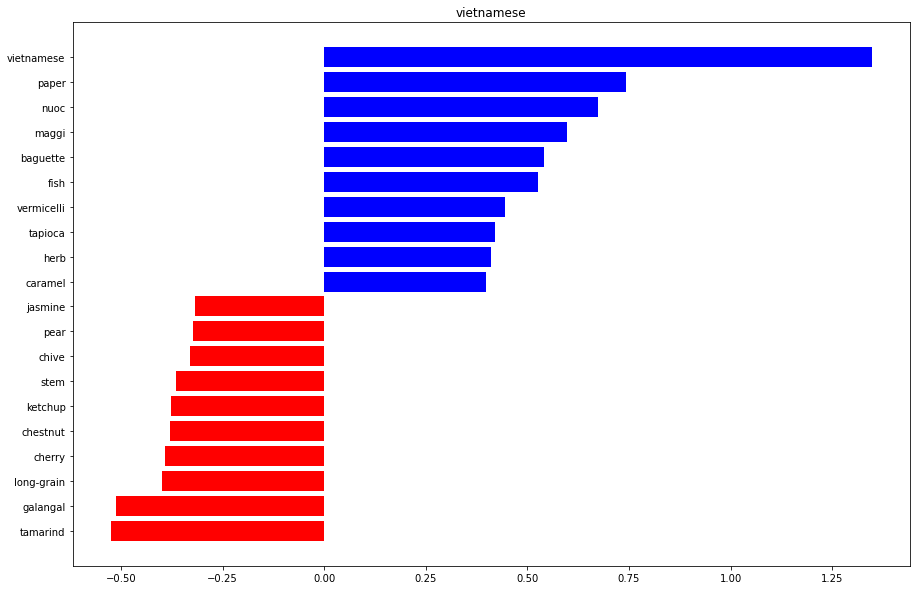

In [178]:
plot_coefficients(best_estimator, 19, 10)